# Understanding Spiking Networks and Pytorch

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import torch
import torch.nn as nn
from tqdm import tqdm
import pickle

In [2]:
# Setting the device and type will have to change for GPU
dtype = torch.float
device = torch.device("cpu")

### Parameters

In [3]:
# Network Dynamics
time_step = 1e-1
nb_steps = 50

# network set up Neurons = 4
nb_in = 1
nb_rec = 100
nb_out = 2
time = np.arange(0,50,1)

# Data structer parameters
batches = 10
epochs = 100
samples = 10

## Creating input data and labels

In [4]:
# Creating 2 different data classes
x1_torch =torch.randn(batches,samples, nb_steps, 1) * 1 + 1 
x2_torch =torch.randn(batches,samples, nb_steps, 1) * 1 - 1 
x_data = torch.cat((x1_torch, x2_torch), 1)
x_data = x_data.reshape([batches,samples*2, nb_steps,1])

# Creating Labels
y1 = torch.tensor((np.ones((batches,samples,1))), device=device, dtype=torch.int64)
#yz = torch.tensor((np.zeros((batches,samples,1))), device=device, dtype=torch.float)
#y1 = torch.cat((y1, yz), 2)
y2 = torch.tensor((np.zeros((batches,samples, 1))), device=device, dtype=torch.int64)
#y2 = torch.cat((yz, y2), 2)
y_data = torch.cat((y1, y2), 1)
y_data = y_data.reshape((batches,samples*2))

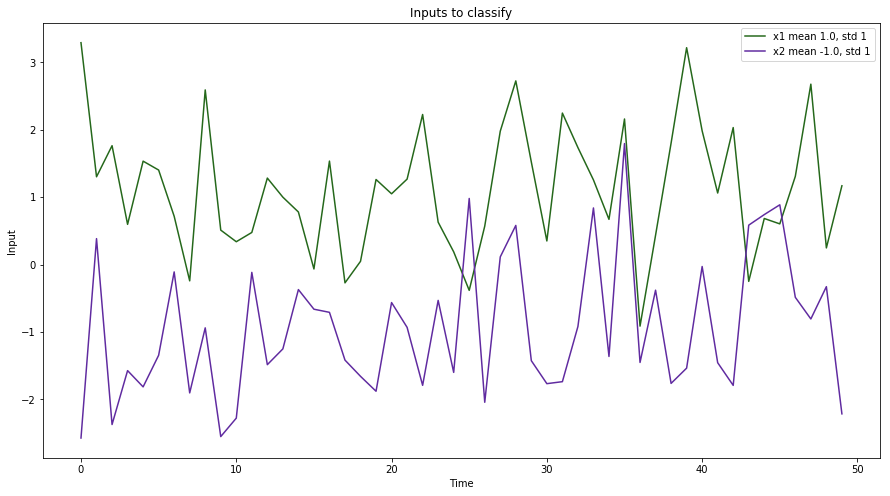

In [5]:
x_plot = x_data.numpy()
plt.figure(figsize=(15,8))
plt.plot(time, x_plot[0,0,:], c = "#25681b", label ="x1 mean 1.0, std 1")
plt.plot(time, x_plot[0,-1,:], c = "#602ba0", label ="x2 mean -1.0, std 1")
plt.title("Inputs to classify")
plt.ylabel("Input")
plt.xlabel("Time")
plt.legend()
plt.savefig("Tensor Input to network")
plt.show()

In [6]:
#Plotting Cumsum over data input
data_trace = torch.cumsum(x_data, 2)
data_trace = data_trace.numpy()

In [7]:
#Plotting Cumsum over data input
data_trace = torch.cumsum(x_data, 2)
data_trace = data_trace.numpy()
y_plot = y_data.numpy()

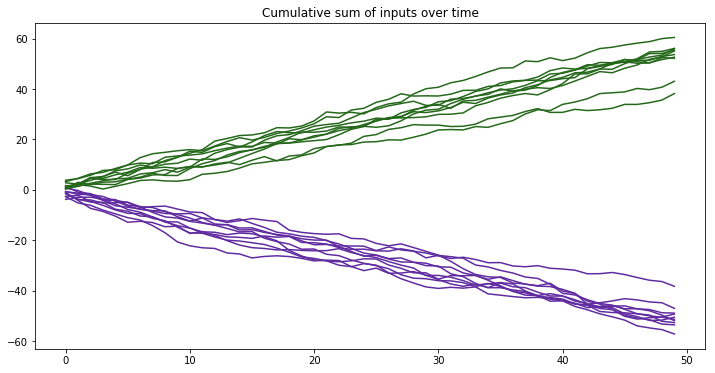

In [8]:
plt.figure(figsize=(12,6))
plt.title("Cumulative sum of inputs over time")
for i in range(samples):
    plt.plot(data_trace[0,i,:], c = "#25681b")
    plt.plot(data_trace[0,i+samples,:], c = "#602ba0")
#     plt.scatter(52, 2*i*y_plot[0,i], c = "#25681b")
#     plt.scatter(52, -2*i +y_plot[0,i+samples], c = "#602ba0")
plt.savefig("Cumulative Sum of inputs")
plt.show()

## Creating Network Architecture

In [10]:
# Neural Parameters
tau_mem = 10e-3
tau_syn = 5e-3
alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_mem))

In [11]:
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

In [12]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

In [13]:
# Want to initialize the weights randomly and from a wise distribution
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with from friedemann

w_rec = torch.empty((nb_rec, nb_rec),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w_rec, mean=0.0, std=weight_scale/np.sqrt(nb_rec))

w_out = torch.empty((nb_rec, nb_out),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w_out, mean=0.0, std=weight_scale/np.sqrt(nb_rec))

w_ff = torch.empty((nb_in,nb_rec),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w_ff, mean=0.0, std=weight_scale/np.sqrt(nb_in))

# Parameters we want to optimize
params = [w_rec, w_ff, w_out]

In [14]:
def run_snn(inputs, w_ff, w_rec, w_out, samples):
    syn = torch.zeros((samples*2,nb_rec), device=device, dtype=dtype)
    mem = torch.zeros((samples*2,nb_rec), device=device, dtype=dtype)
    spk = torch.zeros((samples*2, nb_rec), device=device, dtype=dtype)
    h2 = torch.zeros((samples*2, nb_out), device=device, dtype=dtype)
    
    mem_rec = [mem]
    spk_rec = [mem]
    out_rec = [h2]
    
    ff = torch.einsum("abc,cd->abd", (inputs, w_ff))
    # Compute hidden layer activity
    for t in range(nb_steps-1):
            
            mthr = mem-1.0
            out = spike_fn(mthr)
            rst = torch.zeros_like(mem)
            c   = (mthr > 0)
            rst[c] = torch.ones_like(mem)[c]

            rec = torch.mm(out, w_rec)
            new_syn = alpha*syn + rec + ff[:,t,:]
            new_mem = beta*mem + syn - rst

            mem = new_mem
            syn = new_syn

            mem_rec.append(mem)
            spk_rec.append(out)

        # Readout layer

            h2 = torch.mm(out, w_out)
            out_rec.append(h2)
        
    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)
    out_rec = torch.stack(out_rec,dim=1)

    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [15]:
out_rec, other_recs = run_snn(x_data[0,:,:], w_ff, w_rec, w_out, samples)

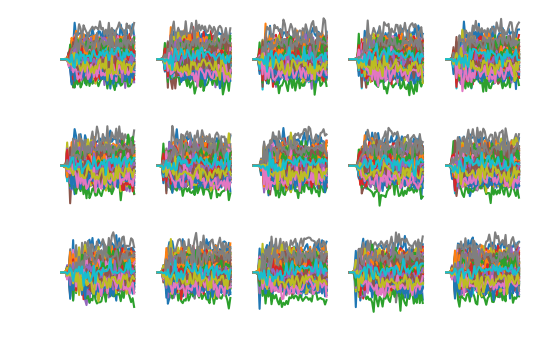

In [16]:
fig=plt.figure(dpi=100)
plot_voltage_traces(other_recs[0],other_recs[1])
plt.savefig("Voltage Traces")

In [17]:
def print_classification_accuracy():
    """ Dirty little helper function to compute classification accuracy. """
#     t_acc = np.empty((batches))
#     for i in range(int(samples*2/batches)):
    output,_ = run_snn(x_data[0,:,:], w_ff, w_rec, w_out, samples)
    m = output[:,-1,:] 
    _,am=torch.max(m,1) # argmax over output units
    am = am.long()
    acc = np.mean((y_data[0,:]==am).detach().cpu().numpy()) # compare to labels
    #t_acc[i] = acc
    #acc = np.mean(t_acc)
    print("Accuracy %.3f"%acc)
    
print_classification_accuracy()

Accuracy 0.500


In [18]:
params = [w_rec, w_ff, w_out] # The paramters we want to optimize
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

log_softmax_fn = nn.LogSoftmax(dim=1) # The log softmax function across output units
loss_fn = nn.NLLLoss() # The negative log likelihood loss function

# The optimization loop
loss_hist = []
out_weights = np.empty((epochs,nb_rec,nb_out))
rec_weights = np.empty((epochs,nb_rec,nb_rec))
in_weights = np.empty((epochs,nb_in,nb_rec))
output = []
for e in tqdm(range(epochs)):
    # run the network and get output
    for b in range(batches):
        output,output_dyn = run_snn(x_data[b,:,:], w_ff, w_rec, w_out, samples) 

        #compute the loss
        am1 = output[:,-1,:]
        log_p_y = log_softmax_fn(am1)
        loss_val = loss_fn(log_p_y, y_data[b,:])

        # update the weights
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
    with torch.no_grad():
        out_weights[e,:,:] = w_out.detach().numpy()
        rec_weights[e,:,:] = w_rec.detach().numpy()
        in_weights[e,:,:] = w_ff.detach().numpy()
    # store loss value
    loss_hist.append(loss_val.item())

loss_hist_true_grad = loss_hist # store for later use

100%|██████████| 100/100 [00:23<00:00,  4.44it/s]


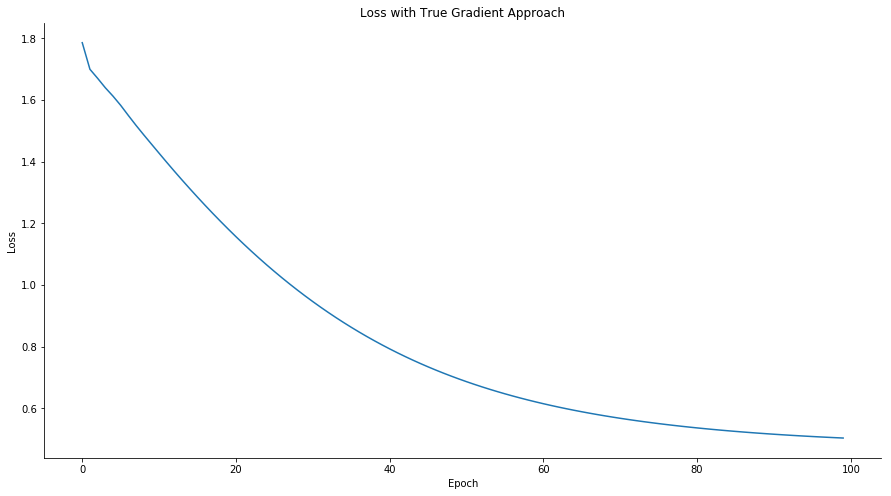

In [19]:
plt.figure(figsize = (15,8))
plt.plot(loss_hist)
plt.title("Loss with True Gradient Approach")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Loss with True Gradient Approach")
sns.despine()

In [20]:
def print_classification_accuracy1():
    """ Dirty little helper function to compute classification accuracy. """
    t_acc1 = np.empty(batches)
    for b in range(batches):
        output1,_ = run_snn(x_data[b,:,:], w_ff, w_rec, w_out, samples)
        m1 = output1[:,-1,:] # max over time
        m1 = m1.long()
        _,am1 = torch.max(m1,1) # argmax over output units
        acc1 = np.mean((y_data[b,:]==am1).detach().cpu().numpy()) # compare to labels
        t_acc1[b] = acc1
    acc1 = np.mean(t_acc1)
    print("Accuracy %.3f"%acc1)
    
print_classification_accuracy1()

Accuracy 0.705


### True Gradient Performance not surprising

In [21]:
weight_out_diff = np.empty((epochs-1,100,2))
weight_rec_diff = np.empty((epochs-1,100,100))
weight_ff_diff = np.empty((epochs-1,1,100))
for i in range(epochs-1):
    weight_out_diff[i] = out_weights[i,:,:] - out_weights[i+1,:,:] 
    weight_rec_diff[i] = rec_weights[i,:,:] - rec_weights[i+1,:,:]
    weight_ff_diff[i] = in_weights[i,:,:] - in_weights[i+1,:,:]

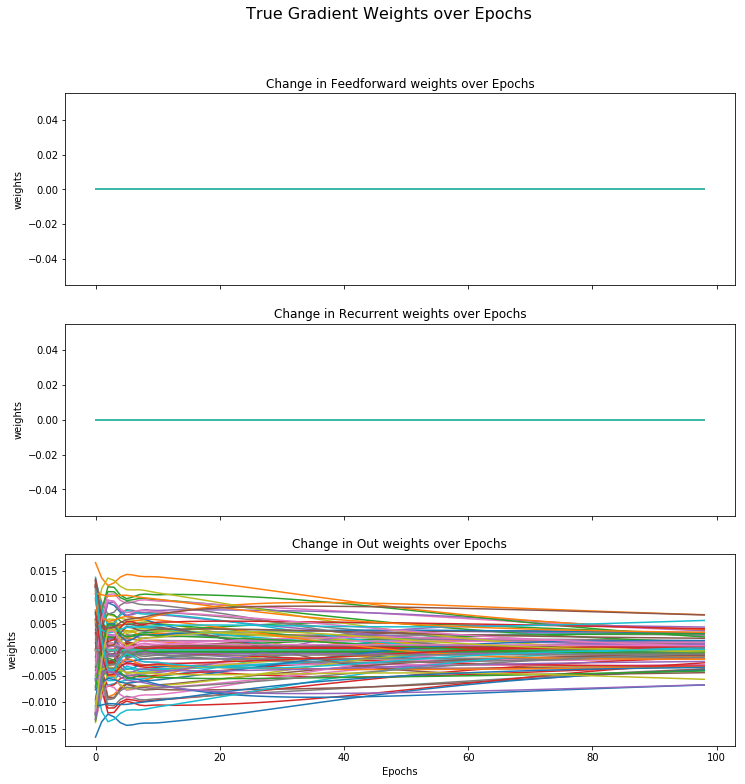

In [22]:
fig, axes = plt.subplots(nrows = 3, ncols=1, sharex = True, figsize=(12,12))
plt.suptitle("True Gradient Weights over Epochs", size=16)
for i in range(50):
    axes[0].plot(weight_ff_diff[:,:,i])
    axes[1].plot(weight_rec_diff[:,:,i])
    axes[2].plot(weight_out_diff[:,i,:])
#axes[0].set_xlabel("Epochs")
axes[1].set_title("Change in Recurrent weights over Epochs")
axes[1].set_ylabel("weights")
axes[2].set_title("Change in Out weights over Epochs")
axes[2].set_ylabel("weights")
#axes[1].set_xlabel("Epochs")    
axes[0].set_title("Change in Feedforward weights over Epochs")
axes[2].set_xlabel("Epochs")
axes[0].set_ylabel("weights")
plt.savefig("True Gradient only Updates Out Weights")
plt.show()

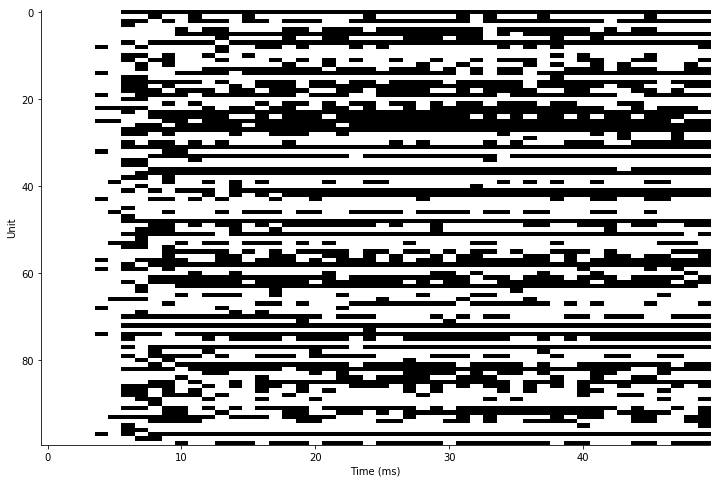

In [23]:
# Spiking Plot
tim_fix = np.arange(0,301,1)

data_id = 0
plt.figure(figsize = (12,8))
plt.imshow(output_dyn[1][0].detach().numpy().T, cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()
plt.savefig("Spikes")

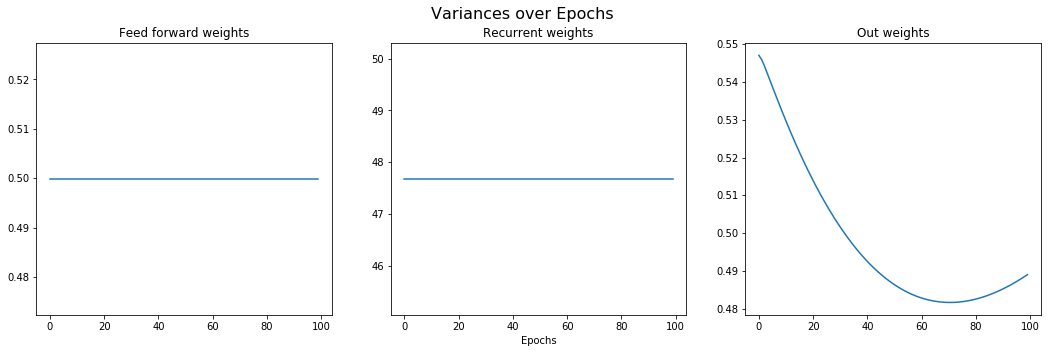

In [24]:
# Plotting the variance over the epochs
var_rec = np.var(rec_weights, axis = (1,2))
var_out = np.var(out_weights, axis = (1,2))
var_ff = np.var(in_weights, axis = (1,2))

fig, axes = plt.subplots(nrows = 1, ncols=3, sharex = True, figsize=(18,5))
plt.suptitle("Variances over Epochs", size=16)
axes[0].plot(var_ff)
axes[0].set_title("Feed forward weights")
axes[1].set_title("Recurrent weights")
axes[1].set_xlabel("Epochs")
axes[2].set_title("Out weights")
axes[1].plot(var_rec)
axes[2].plot(var_out)
plt.savefig("weight varience true gradient")
plt.show()

### SuperSpike with Gradient

In [25]:
class SuperSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SuperSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SuperSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SuperSpike.apply

In [36]:
w_rec_sur = torch.empty((nb_rec, nb_rec),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w_rec_sur, mean=0.0, std=weight_scale/np.sqrt(nb_rec))

w_out_sur = torch.empty((nb_rec, nb_out),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w_out_sur, mean=0.0, std=weight_scale/np.sqrt(nb_rec))

w_ff_sur = torch.empty((nb_in, nb_rec),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w_ff_sur, mean=0.0, std=weight_scale/np.sqrt(nb_in))

# Parameters we want to optimize
params_rec = [w_ff_sur, w_rec_sur, w_out_sur]

In [54]:
optimizer = torch.optim.Adam(params_rec, lr=1e-5, betas=(0.9,0.999))
loss_fn = nn.NLLLoss()
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_hist = []
out_weights_s = np.empty((epochs,nb_rec,nb_out))
rec_weights_s = np.empty((epochs,nb_rec,nb_rec))
in_weights_s = np.empty((epochs,nb_in,nb_rec))
for e in tqdm(range(epochs)):

    for b in range(batches):
        output_sur,out_dyn_sur = run_snn(x_data[b,:,:], w_ff_sur, w_rec_sur, w_out_sur, samples)

        #compute the loss
        y_data.float()
        m_sur = output_sur[:,-1,:]
        log_p_y_sur = log_softmax_fn(m_sur)
        loss_val_sur = loss_fn(log_p_y_sur, y_data[b,:])
        
        optimizer.zero_grad()
        loss_val_sur.backward()
        optimizer.step()
        
    with torch.no_grad():
        out_weights_s[e,:,:] = w_out_sur.detach().numpy()
        rec_weights_s[e,:,:] = w_rec_sur.detach().numpy()
        in_weights_s[e,:,:] = w_ff_sur.detach().numpy()
    if e % (epochs / 10) == 0:
        print(e, loss_val_sur.item())
    loss_hist.append(loss_val_sur.item())

  1%|          | 1/100 [00:00<00:53,  1.85it/s]

0 0.6467369794845581


 11%|█         | 11/100 [00:05<00:43,  2.04it/s]

10 0.5552864074707031


 21%|██        | 21/100 [00:10<00:40,  1.95it/s]

20 0.7292593121528625


 31%|███       | 31/100 [00:15<00:34,  2.01it/s]

30 0.7501858472824097


 41%|████      | 41/100 [00:20<00:32,  1.80it/s]

40 0.7493787407875061


 51%|█████     | 51/100 [00:26<00:27,  1.77it/s]

50 0.7796133160591125


 61%|██████    | 61/100 [00:31<00:21,  1.86it/s]

60 0.6937662363052368


 71%|███████   | 71/100 [00:36<00:14,  2.02it/s]

70 0.7039912343025208


 81%|████████  | 81/100 [00:41<00:09,  2.02it/s]

80 0.7112860083580017


 91%|█████████ | 91/100 [00:46<00:04,  2.06it/s]

90 0.7996878623962402


100%|██████████| 100/100 [00:51<00:00,  2.00it/s]


In [49]:
with torch.no_grad():
    output_sur = output_sur.detach().numpy()

In [50]:
output_sur.shape

(20, 50, 2)

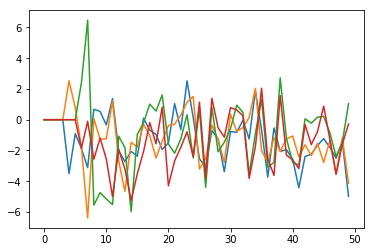

In [51]:


plt.figure()
plt.plot(output_sur[0,:,:])
plt.plot(output_sur[-1,:,:])
plt.show()

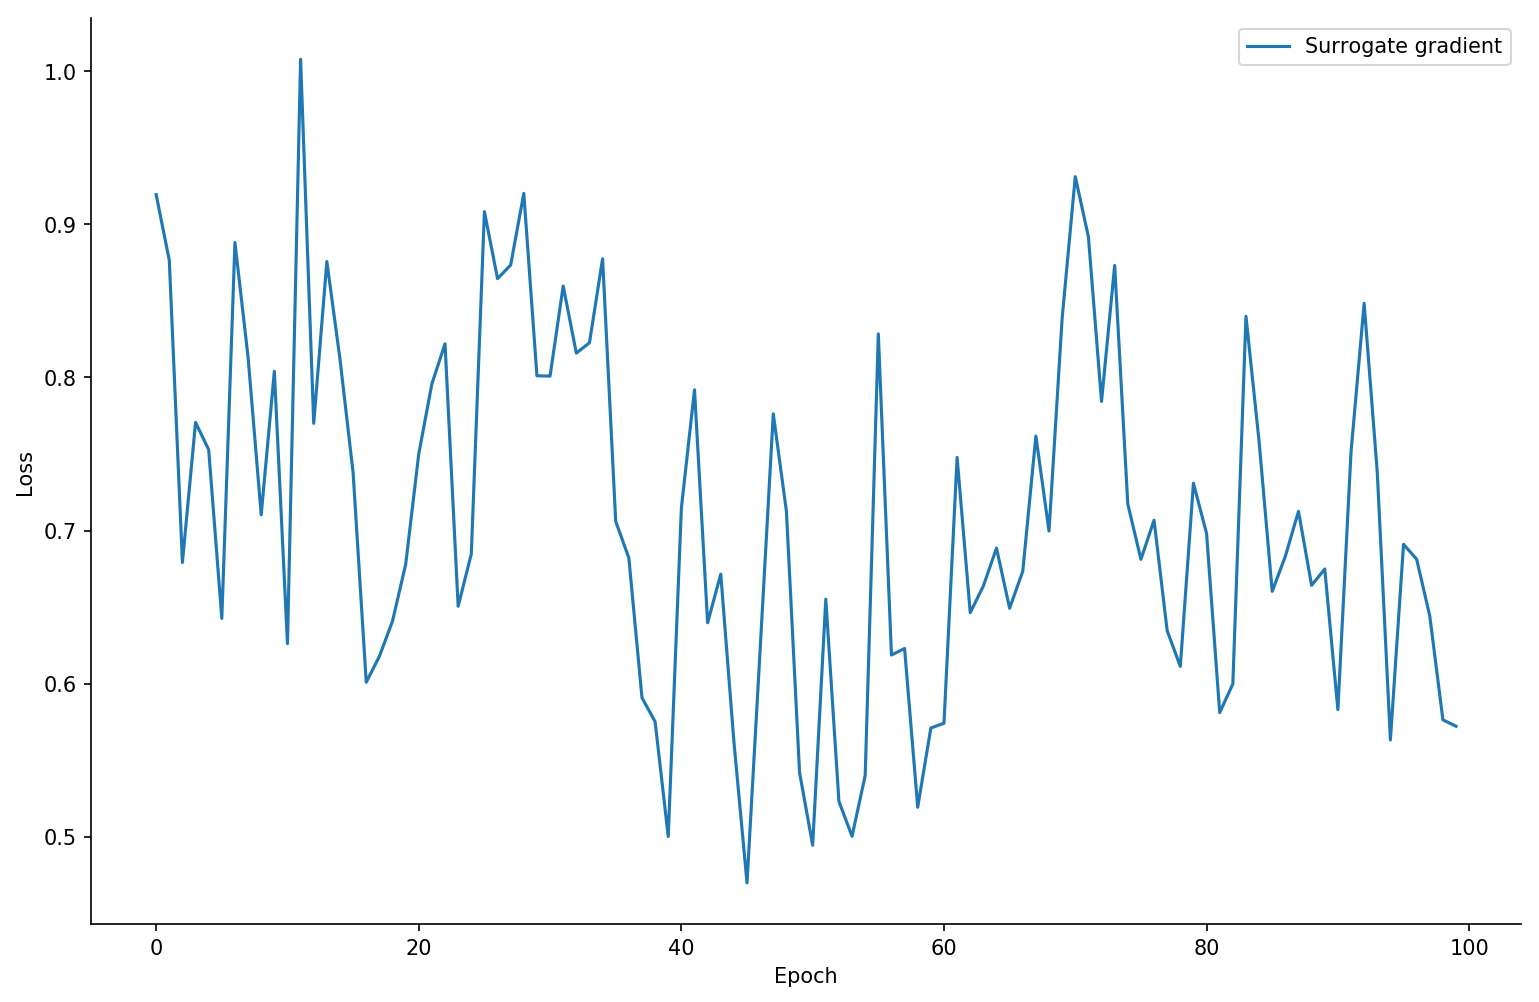

In [52]:
plt.figure(figsize=(12.3,8),dpi=150)
plt.plot(loss_hist, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Initial Results with 100 neurons")
sns.despine()

In [39]:
def print_classification_accuracy2():
    """ Dirty little helper function to compute classification accuracy. """
    t_acc2 = np.empty(batches)
    for b in range(batches):
        output2,_ = run_snn(x_data[b,:,:], w_ff_sur, w_rec_sur, w_out_sur, samples)
        m2 = output2[:,-1,:]
        m2 = m2.long()
        _,am2 = torch.max(m2,1) # argmax over output units
        acc2 = np.mean((y_data[b,:]==am2).detach().cpu().numpy()) # compare to labels
        t_acc2[b] = acc2
    acc2 = np.mean(t_acc2)
    print("Accuracy %.3f"%acc2)
    
print_classification_accuracy2()

Accuracy 0.515


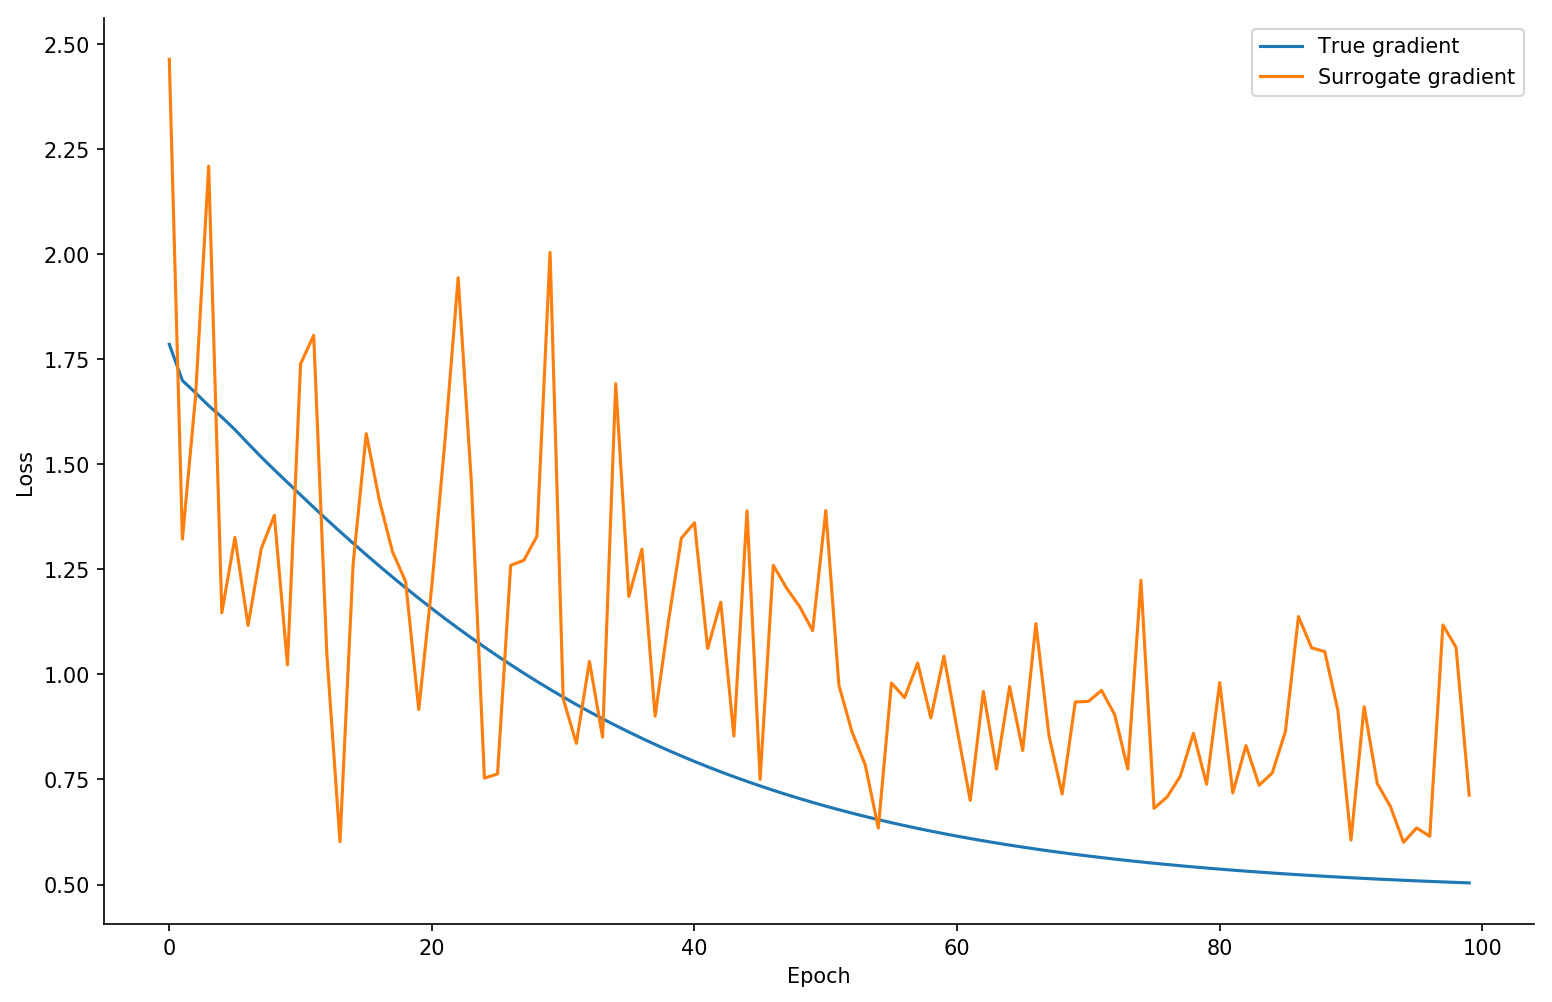

In [40]:
plt.figure(figsize=(12.3,8),dpi=150)
plt.plot(loss_hist_true_grad, label="True gradient")
plt.plot(loss_hist, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Initial Results with 100 neurons")
sns.despine()

In [41]:
weight_os_diff = np.empty((epochs-1,100,2))
weight_rs_diff = np.empty((epochs-1,100,100))
weight_fs_diff = np.empty((epochs-1,1,100))
for i in range(epochs-1):
    weight_os_diff[i] = out_weights_s[i,:,:] - out_weights_s[i+1,:,:] 
    weight_rs_diff[i] = rec_weights_s[i,:,:] - rec_weights_s[i+1,:,:]
    weight_fs_diff[i] = in_weights_s[i,:,:] - in_weights_s[i+1,:,:]

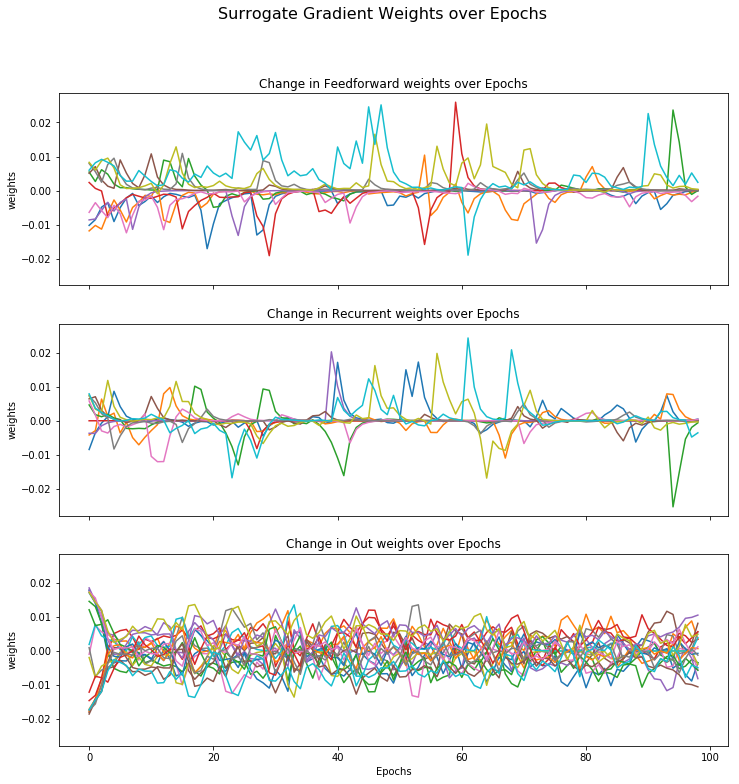

In [42]:
fig, axes = plt.subplots(nrows = 3, ncols=1, sharex = True, sharey=True, figsize=(12,12))
plt.suptitle("Surrogate Gradient Weights over Epochs", size=16)
for i in range(10):
    axes[0].plot(weight_fs_diff[:,:,i])
    axes[1].plot(weight_rs_diff[:,i,i])
    axes[2].plot(weight_os_diff[:,i,:])
axes[1].set_title("Change in Recurrent weights over Epochs")
axes[1].set_ylabel("weights")
axes[2].set_title("Change in Out weights over Epochs")
axes[2].set_ylabel("weights")   
axes[0].set_title("Change in Feedforward weights over Epochs")
axes[2].set_xlabel("Epochs")
axes[0].set_ylabel("weights")
plt.savefig("Surrogate Gradient weight updates")
plt.show()

In [43]:
var_outs = np.var(out_weights_s, axis = (1,2))
var_recs = np.var(rec_weights_s, axis = (1,2))
var_ins = np.var(in_weights_s, axis = (1,2))

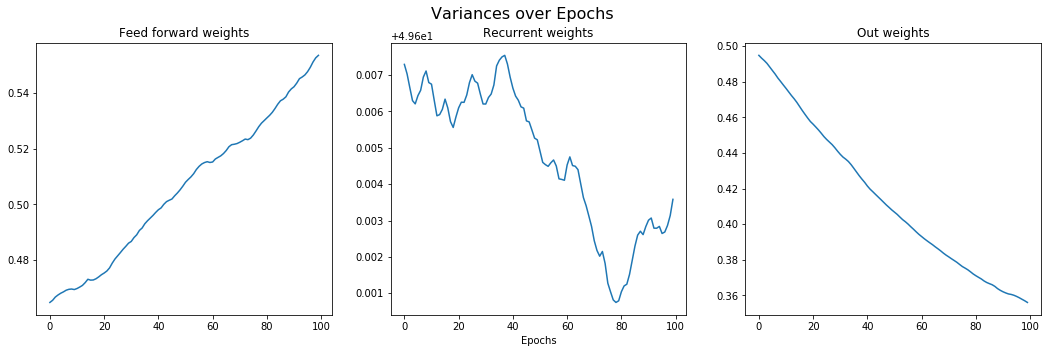

In [44]:
# Plotting the variance over the epochs
fig, axes = plt.subplots(nrows = 1, ncols=3, sharex = True, figsize=(18,5))
plt.suptitle("Variances over Epochs", size=16)
axes[0].plot(var_ins)
axes[0].set_title("Feed forward weights")
axes[1].set_title("Recurrent weights")
axes[1].set_xlabel("Epochs")
axes[2].set_title("Out weights")
axes[1].plot(var_recs)
axes[2].plot(var_outs)
plt.savefig("weight variance over epochs")
plt.show()

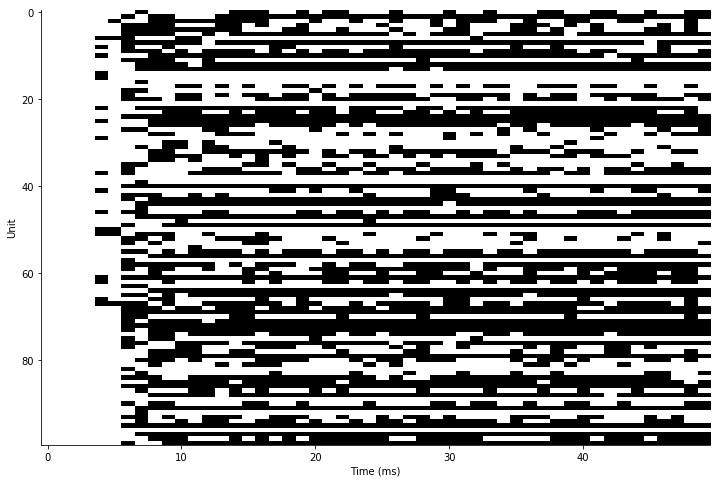

In [35]:
# Spiking Plot
tim_fix = np.arange(0,301,1)

data_id = 0
plt.figure(figsize = (12,8))
plt.imshow(out_dyn_sur[1][0].detach().numpy().T, cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()
plt.savefig("Surrogate Spikes")

# Understanding the network at hidden state

In [ ]:
syn = torch.zeros((samples,nb_rec), device=device, dtype=dtype)
mem = torch.zeros((samples,nb_rec), device=device, dtype=dtype)
spk = torch.zeros((samples, nb_rec), device=device, dtype=dtype)

v1 = torch.einsum("abc,cd->abd", (x_data[0,:,:,:], w_ff))
h1 = torch.einsum("ab,bc->ac", (spk, w_rec))

# Here we define two lists which we use to record the membrane potentials and output spikes
mem_rec = [mem]
spk_rec = [mem]

# Here we loop over time
for t in range(nb_steps):
    mthr = mem-1.0
    out = spike_fn(mthr)
    rst = torch.zeros_like(mem)
    c = (mthr > 0)
    rst[c] = torch.ones_like(mem)[c]
    new_spike = rst
    
    new_syn = alpha*syn + h1 + v1[:,t]
    new_mem = beta*mem + syn - rst
    
    mem = new_mem
    syn = new_syn
    spk = new_spike 
    
    mem_rec.append(mem)
    spk_rec.append(out)
    
# Now we merge the recorded membrane potentials into a single tensor
mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

# JcJohnson Pytorch tutorial

### I. Numpy Implementation

In [ ]:
import numpy as np

"""
A fully-connected ReLU network with one hidden layer and no biases, trained to
predict y from x using Euclidean error.

This implementation uses numpy to manually compute the forward pass, loss, and
backward pass.

A numpy array is a generic n-dimensional array; it does not know anything about
deep learning or gradients or computational graphs, and is just a way to perform
generic numeric computations.
"""

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

learning_rate = 1e-6
for t in range(500):
  # Forward pass: compute predicted y
  h = x.dot(w1)
  h_relu = np.maximum(h, 0)
  y_pred = h_relu.dot(w2)
  
  # Compute and print loss
  loss = np.square(y_pred - y).sum()
  print(t, loss)
  
  # Backprop to compute gradients of w1 and w2 with respect to loss
  grad_y_pred = 2.0 * (y_pred - y)
  grad_w2 = h_relu.T.dot(grad_y_pred)
  grad_h_relu = grad_y_pred.dot(w2.T)
  grad_h = grad_h_relu.copy()
  grad_h[h < 0] = 0
  grad_w1 = x.T.dot(grad_h)
 
  # Update weights
  w1 -= learning_rate * grad_w1
  w2 -= learning_rate * grad_w2

### II. Torch implementation

In [ ]:
# Code in file tensor/two_layer_net_tensor.py
import torch

device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device)
w2 = torch.randn(H, D_out, device=device)

learning_rate = 1e-6
for t in range(500):
  # Forward pass: compute predicted y
  h = x.mm(w1)
  h_relu = h.clamp(min=0)
  y_pred = h_relu.mm(w2)

  # Compute and print loss; loss is a scalar, and is stored in a PyTorch Tensor
  # of shape (); we can get its value as a Python number with loss.item().
  loss = (y_pred - y).pow(2).sum()
  print(t, loss.item())

  # Backprop to compute gradients of w1 and w2 with respect to loss
  grad_y_pred = 2.0 * (y_pred - y)
  grad_w2 = h_relu.t().mm(grad_y_pred)
  grad_h_relu = grad_y_pred.mm(w2.t())
  grad_h = grad_h_relu.clone()
  grad_h[h < 0] = 0
  grad_w1 = x.t().mm(grad_h)

  # Update weights using gradient descent
  w1 -= learning_rate * grad_w1
  w2 -= learning_rate * grad_w2

### III. Autogradient

In [ ]:
# Code in file tensor/two_layer_net_tensor.py
import torch

device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
  # Forward pass: compute predicted y
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

  # Compute and print loss; loss is a scalar, and is stored in a PyTorch Tensor
  # of shape (); we can get its value as a Python number with loss.item().
    loss = (y_pred - y).pow(2).sum()
    print(t, loss.item())

  # Backprop to compute gradients of w1 and w2 with respect to loss
#   grad_y_pred = 2.0 * (y_pred - y)
#   grad_w2 = h_relu.t().mm(grad_y_pred)
#   grad_h_relu = grad_y_pred.mm(w2.t())
#   grad_h = grad_h_relu.clone()
#   grad_h[h < 0] = 0
#   grad_w1 = x.t().mm(grad_h)
    loss.backward()
    with torch.no_grad():
      # Update weights using gradient descent
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        w1.grad.zero_()
        w2.grad.zero_()

### Making own gradient function

In [ ]:
# Code in file autograd/two_layer_net_custom_function.py
import torch

class MyReLU(torch.autograd.Function):
  """
  We can implement our own custom autograd Functions by subclassing
  torch.autograd.Function and implementing the forward and backward passes
  which operate on Tensors.
  """
  @staticmethod
  def forward(ctx, x):
    """
    In the forward pass we receive a context object and a Tensor containing the
    input; we must return a Tensor containing the output, and we can use the
    context object to cache objects for use in the backward pass.
    """
    ctx.save_for_backward(x)
    return x.clamp(min=0)

  @staticmethod
  def backward(ctx, grad_output):
    """
    In the backward pass we receive the context object and a Tensor containing
    the gradient of the loss with respect to the output produced during the
    forward pass. We can retrieve cached data from the context object, and must
    compute and return the gradient of the loss with respect to the input to the
    forward function.
    """
    x, = ctx.saved_tensors
    grad_x = grad_output.clone()
    grad_x[x < 0] = 0
    return grad_x


device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and output
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Create random Tensors for weights.
w1 = torch.randn(D_in, H, device=device, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
  # Forward pass: compute predicted y using operations on Tensors; we call our
  # custom ReLU implementation using the MyReLU.apply function
  y_pred = MyReLU.apply(x.mm(w1)).mm(w2)
 
  # Compute and print loss
  loss = (y_pred - y).pow(2).sum()
  print(t, loss.item())

  # Use autograd to compute the backward pass.
  loss.backward()

  with torch.no_grad():
    # Update weights using gradient descent
    w1 -= learning_rate * w1.grad
    w2 -= learning_rate * w2.grad

    # Manually zero the gradients after running the backward pass
    w1.grad.zero_()
    w2.grad.zero_()

In [ ]:
# Code in file nn/two_layer_net_nn.py
import torch

device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# After constructing the model we use the .to() method to move it to the
# desired device.
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        ).to(device)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function. Setting
# reduction='sum' means that we are computing the *sum* of squared errors rather
# than the mean; this is for consistency with the examples above where we
# manually compute the loss, but in practice it is more common to use mean
# squared error as a loss by setting reduction='elementwise_mean'.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
  # Forward pass: compute predicted y by passing x to the model. Module objects
  # override the __call__ operator so you can call them like functions. When
  # doing so you pass a Tensor of input data to the Module and it produces
  # a Tensor of output data.
  y_pred = model(x)

  # Compute and print loss. We pass Tensors containing the predicted and true
  # values of y, and the loss function returns a Tensor containing the loss.
  loss = loss_fn(y_pred, y)
  print(t, loss.item())
  
  # Zero the gradients before running the backward pass.
  model.zero_grad()

  # Backward pass: compute gradient of the loss with respect to all the learnable
  # parameters of the model. Internally, the parameters of each Module are stored
  # in Tensors with requires_grad=True, so this call will compute gradients for
  # all learnable parameters in the model.
  loss.backward()

  # Update the weights using gradient descent. Each parameter is a Tensor, so
  # we can access its data and gradients like we did before.
  with torch.no_grad():
    for param in model.parameters():
      param.data -= learning_rate * param.grad

In [ ]:
y.shape

## Friedemann's Technique with Leaky Integrate and Fire

#### Creating Data: Input and output for numpy

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(time, x1_data[:,0], label ="x1 mean 0.5, std 1")
plt.plot(time, x2_data[:,0], label ="x2 mean -0.5, std 1")
plt.title("Inputs to classify")
plt.ylabel("Input")
plt.xlabel("Time")
plt.legend()
plt.savefig("Input to network")
plt.show()

In [ ]:
from pylab import *
from numpy import *

In [ ]:
def ForwardEuler(t,I,w0 = 0,v0=-70,Params={'a':0,'EL':-70.0,'tauw':10,'b':0,'Ereset':-73,'gL':4.0,'vT':-50,'DT':2,'C':40}):
    """
    solve the original TypeY model
    using Euler's method

    Inputs:
       t   - equally spaced time bins (ms)
             e.g. arange(0,100,0.1)
             
       I   - current input to LIF,
             same shape as t 
    OUPTUT
    [v,w,spks]
    the timeseries of the voltage (v, in mV), and the slow recovery variable (w) and spike times (spks)
    ALGORITHM
    uses the equations and parameters given in 'Spiking Neuron Models' p70-71.
    These parameters are based on the voltage scale where the resting potential is zero.
    """
    
    # simple error check
    if I.shape!=t.shape:
        raise TypeError; 'require I.shape == t.shape'
    
    L = len(t)
    dt = t[1]-t[0]

    # allocate array for voltage and gating variables
    v = zeros(I.shape) # this sets initial condition of v to be zero as required
    w = zeros(I.shape)
    I = array(I).astype(float)
    
    # let initial value be m_inf(initial voltage), etc.
    v[0] = v0
    w[0] = w0
    a=Params.get('a')
    EL= Params.get('EL')
    tauw=Params.get('tauw')
    b=Params.get('b')
    Ereset = Params.get('Ereset')
    
    i=0
    spks = array([])
    while i <len(I)-1:
        # forward euler step
        i=i+1
        v[i] = v[i-1] + dudt(v[i-1],w[i-1], I[i-1],Params)*dt
        w[i] = w[i-1] + ((a*(v[i-1]-EL)-w[i-1])/tauw)*dt
        if v[i]>0:
            v[i:i+4]=0
            w[i:i+4]=w[i]
            v[i+5]=Ereset
            w[i+5]=w[i]+b
            spks = append(spks,i)
            i=i+5
    
    return [v, w,spks]

# define derivatives; factor 1e3 needed for t in ms

def dudt(v,w,I,Params={'gL':4.0,'EL':-70.0,'vT':-50,'DT':2,'C':40}):
    """
    This is the first equation of the TypeY system, the voltage ordinary differential equation

    INPUTS
    (state variables)
    u: voltage (float)
    w: recovery variable (float)
    
    I: current (float)
    Params: dictionary with gL, EL, EL vT DT C

    """
    gL=Params.get('gL')
    EL=Params.get('EL')
    vT=Params.get('vT')
    DT=Params.get('DT')
    C=Params.get('C')
    
    dudt = -gL*(v-EL)/C +gL*exp((v-vT)/DT)/C+ I/C -w/C
    return dudt



In [ ]:
# Equation for spike count returns vector of zeros and ones
def spikes(u):
    spikes = torch.zeros_like(u)
    spikes[u >= 0.0] = 1.0
    return spikes

In [ ]:
def Step(tstart=0, tend=300, Step_tstart = 20, Step_tend = 270, I_amp=.5, dt=0.01):
    """
    DEFINITION
    Runs the TypeY model for a step current.
    
    INPUT
    tstart: starting time (ms)
    tend: ending time (ms)
    Step_tstart: time at which the step current begins (ms)
    Step_tend: time  at which the step current ends (ms)
    I_amp: magnitude of the current step (uA/cm^2)
    dt: integration timestep
    
    OUTPUT

    [t,v,w,I]
    
    t - arange(tstart,tend,dt)
    v - voltage trace
    w - slow recovery variable
    I - current injected
  
    
    ALGORITHM
    uses Forward-Euler numerical integration in ForwardEuler
    
    -R.Naud 02.2009.
    """

    # make time bins
    t = arange(tstart,tend,dt)  
    # make current array for each time bin
    I = zeros(t.shape)

    # find array index of I start and stop times
    index_start = searchsorted(t,Step_tstart)
    index_end = searchsorted(t,Step_tend)
    # assign amplitude to that range
    I[index_start:index_end] = I_amp

    # run the integrator
    [v, w] = ForwardEuler(t,I)
    return [t,v,w,I]

In [ ]:
def PlotStep(tstart=0, tend=300, Step_tstart = 20, Step_tend = 270, I_amp=.5, dt=0.01):
    """
    
    DEFINITION
    Plots the TypeY model for a step current.
    
    INPUT
    tstart: starting time (ms)
    tend: ending time (ms)
    Step_tstart: time at which the step current begins (ms)
    Step_tend: time  at which the step current ends (ms)
    I_amp: magnitude of the current step (uA/cm^2)
    dt: integration timestep
    
    OUTPUT
    graph with three panels: 1) voltage trace, 2) slow recovery variable w 3) current injected.

    """

    t,v,w,I = Step(tstart, tend, Step_tstart, Step_tend, I_amp, dt)

    # open new figure and plot
    figure()
    # plot voltage time series
    subplot(311)
    plot(t,v,lw=2)
    xlabel('t')
    ylabel('v')
    # plot activation and inactivation variables
    subplot(312)
    plot(t,w,'k',lw=2)
    xlabel('t')
    ylabel('w')
    # plot current
    subplot(313)
    plot(t,I,lw=2)
    axis((tstart, tend, 0, I_amp*1.1))
    xlabel('t (ms)')
    ylabel('I (pA)')

In [ ]:
plt.figure()
plt.plot(t,v2[1,:])
plt.plot(t,v[0,:])
plt.show()

In [ ]:
t = arange(0,300,1)
I = np.zeros((300))
I[100:200] = 50
I2 = np.zeros((300))
I2[100:200] = 100
[v, w,spks] = ForwardEuler(t,I,w0 = 0,v0=-70,Params={'a':0,'EL':-70.0,'tauw':10,'b':0,'Ereset':-73,'gL':4.0,'vT':-50,'DT':2,'C':40})
[v2, w2,spks2] = ForwardEuler(t,I2,w0 = 0,v0=-70,Params={'a':0,'EL':-70.0,'tauw':10,'b':0,'Ereset':-73,'gL':4.0,'vT':-50,'DT':2,'C':40})

In [ ]:
plt.figure(figsize=(8,4))
plt.title("Single LIF Neurons")
plt.ylabel("Voltage (mV)")
plt.xlabel("Time")
plt.plot(t,v)
plt.plot(t,v2)
plt.show()

# LIF with Adaptaton

In [ ]:
def ForwardEuler3(t,I,w0 = 0,v0=-70,Params={'a':0,'EL':-70.0,'tauw':10,'b':0,'Ereset':-73,'gL':4.0,'vT':-50,'DT':2,'C':40,'a2':0,'a3':0,'b2':0,'b3':0, 'tauw2':10,'tauw3':10}):
    """
    solve the original TypeY model
    using Euler's method

    Inputs:
       t   - equally spaced time bins (ms)
             e.g. arange(0,100,0.1)
             
       I   - current input to LIF,
             same shape as t 
    OUPTUT
    [v,w]
    the timeseries of the voltage (v, in mV), and the slow recovery variable (w) 
    ALGORITHM
    uses the equations and parameters given in 'Spiking Neuron Models' p70-71.
    These parameters are based on the voltage scale where the resting potential is zero.
    """
    
    # simple error check
    if I.shape!=t.shape:
        raise TypeError; 'require I.shape == t.shape'
    
    L = len(t)
    dt = t[1]-t[0]

    # allocate array for voltage and gating variables
    v = zeros(I.shape) # this sets initial condition of v to be zero as required
    w = zeros(I.shape)
    w2 = zeros(I.shape)
    w3 = zeros(I.shape)
    I = array(I).astype(float)
    
    # let initial value be m_inf(initial voltage), etc.
    v[0] = v0
    w[0] = w0
    w2[0] = w0
    w3[0] = w0
    a=Params.get('a')
    a2 = Params.get('a2')
    a3 = Params.get('a3')
    b2 = Params.get('b2')
    b3 = Params.get('b3')
    EL= Params.get('EL')
    tauw=Params.get('tauw')
    tauw2 = Params.get('tauw2')
    tauw3 = Params.get('tauw3')
    b=Params.get('b')
    Ereset = Params.get('Ereset')
    
    i=0
    spks = array([])
    while i <len(I)-1:
        # forward euler step
        i=i+1
        v[i] = v[i-1] + dudt3(v[i-1],w[i-1],w2[i-1],w3[i-1], I[i-1],Params)*dt
        w[i] = w[i-1] + ((a*(v[i-1]-EL)-w[i-1])/tauw)*dt
        w2[i] = w2[i-1] + ((a2*(v[i-1]-EL)-w2[i-1])/tauw2)*dt
        w3[i] = w3[i-1] + ((a3*(v[i-1]-EL)-w3[i-1])/tauw3)*dt
        if v[i]>0:
            v[i:i+4]=0
            w[i:i+4]=w[i]
            w2[i:i+4] = w2[i]
            w3[i:i+4] = w3[i]
            v[i+5]=Ereset
            w[i+5]=w[i]+b
            w2[i+5] = w2[i] + b2
            w3[i+5] = w3[i] + b3
            spks = append(spks,i)
            i=i+5
    
    return [v, w,w2,w3,spks]

def dudt3(v,w,w2,w3,I,Params={'gL':4.0,'EL':-70.0,'vT':-50,'DT':2,'C':40}):
    """
    This is the first equation of the TypeY system, the voltage ordinary differential equation

    INPUTS
    (state variables)
    u: voltage (float)
    w: recovery variable (float)
    
    I: current (float)
    Params: dictionary with gL, EL, EL vT DT C

    """
    gL=Params.get('gL')
    EL=Params.get('EL')
    vT=Params.get('vT')
    DT=Params.get('DT')
    C=Params.get('C')
    
    dudt = -gL*(v-EL)/C +gL*exp((v-vT)/DT)/C+ I/C -w/C - w2/C - w3/C
    return dudt